In [40]:
from datetime import datetime as dt, timedelta
import json
import sys
import time

import concurrent
from functools import partial
import multiprocessing.dummy as mp 
from multiprocessing import Pool, Manager, cpu_count, Manager , Process
from multiprocessing.pool import ThreadPool
import multiprocessing

from statistics import median, mean, stdev
import warnings

from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from requests import Session
import seaborn as sns
import ta


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
#!{sys.executable} -m pip install seaborn

HEADERS = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) '\
                         'AppleWebKit/537.36 (KHTML, like Gecko) '\
                         'Chrome/75.0.3770.80 Safari/537.36'}

In [572]:
!pip install [package_name] --upgrade

appnope==0.1.0
attrs==19.3.0
backcall==0.1.0
beautifulsoup4==4.9.0
bleach==3.1.0
bs4==0.0.0
certifi==2020.4.5.1
chardet==3.0.4
cycler==0.10.0
decorator==4.4.1
defusedxml==0.6.0
entrypoints==0.3
idna==2.9
importlib-metadata==1.5.0
ipykernel==5.1.4
ipython==7.12.0
ipython-genutils==0.2.0
jedi==0.16.0
Jinja2==2.11.1
json5==0.9.1
jsonschema==3.2.0
jupyter-client==5.3.4
jupyter-console==6.1.0
jupyter-core==4.6.3
jupyterlab==1.2.6
jupyterlab-server==1.0.6
jupyterthemes==0.20.0
kiwisolver==1.2.0
lesscpy==0.14.0
MarkupSafe==1.1.1
matplotlib==3.2.1
mistune==0.8.4
more-itertools==8.2.0
nbconvert==5.6.1
nbformat==5.0.4
notebook==6.0.3
numpy==1.18.2
pandas==1.0.3
pandocfilters==1.4.2
parso==0.6.1
pexpect==4.8.0
pickleshare==0.7.5
ply==3.11
prometheus-client==0.7.1
prompt-toolkit==3.0.3
ptyprocess==0.6.0
pyarrow==0.17.0
Pygments==2.5.2
pyparsing==2.4.7
pyrsistent==0.15.7
python-dateutil==2.8.1
pytz==2019.3
pyzmq==18.1.1
requests==2.23.0
scipy==1.4.1
seaborn==0.10.1
Send2Trash==1.5.0
six==1.14.0
sou

Extract Data from finviz

In [72]:
def finviz_pull(url):
    # Finviz with filters: Average Volume > 500k / RSI 40 / Current Volume > 1M / Market Cap +Small (no Micro)
    #url = 'https://finviz.com/screener.ashx?v=131&f=sh_avgvol_o500,sh_curvol_o1000,ta_rsi_os40'
    #url = 'https://finviz.com/screener.ashx?v=131&f=cap_smallover,sh_avgvol_o500,sh_curvol_o1000,ta_rsi_os40'
    #url = 'https://finviz.com/screener.ashx?v=131&f=cap_smallover,sh_avgvol_o500,sh_curvol_o500&ft=3&o=-volume'
    
    # Create Session
    s = Session()
    
    # Add headers
    s.headers.update(HEADERS)
    
    # Extract data from Finviz - parse html
    screener = s.get(url)
    soup = BeautifulSoup(screener.text, 'html.parser')

    # Figure out number of stocks
    total_stocks_element = soup.find(class_ = 'count-text').text[7:]
    stop_position = total_stocks_element.find(' ')
    total_stocks = int(total_stocks_element[:stop_position])
    
    # Empty list to store stocks
    my_stocks = []

    # Pages and number of stocks
    page = 1
    stocks_imported = 0
    
    while stocks_imported < total_stocks:
        
        # Create new url
        new_url = url + '&r=' + str(page)

        # Pull data and parse html
        stock_data = s.get(new_url)
        soup = BeautifulSoup(stock_data.text, 'html.parser')

        # Table with stocks
        table_element_1 = soup.find_all(class_='table-dark-row-cp')
        table_element_2 = soup.find_all(class_='table-light-row-cp')
        table_element = table_element_1 + table_element_2
        
        # For each line extract the symbol, name and industry
        for idx, row in enumerate(table_element):
            
            # Creating table with all 'a' elements
            symbol_table = row.find_all('a')
            
            # Symbol
            symbol = symbol_table[1].text
            # Name
            symbol_name = symbol_table[2].text
            # Industry
            symbol_sector = symbol_table[3].text
            
            # Append all
            my_stocks.append([symbol, symbol_name, symbol_sector])
            
            stocks_imported += 1
            
        if stocks_imported == total_stocks:
            print(f"Total of {stocks_imported} stocks imported")
            print('Done loading')
        
        else:
            print(f"{stocks_imported} stocks imported")
            page += 20
            
    return my_stocks

Function to query data

In [73]:
def yahoo_finance_query(symbol, period1_date, period2_date, interval='1d', pre_post = 'false'):
    # Convert dates to timestamps
    period1 = int(time.mktime(time.strptime((period1_date + ' 00:00:00'), '%Y-%m-%d %H:%M:%S')))
    period2 = int(time.mktime(time.strptime((period2_date), '%Y-%m-%d %H:%M:%S')))
    
    # Headers
    s = Session()

    # Add headers
    s.headers.update(HEADERS)
    
    # Create url
    params = {"symbol": symbol, 
              "period1": period1, 
              "period2": period2,
              "interval": interval, 
              "includePrePost": pre_post}
    
    url = f'https://query1.finance.yahoo.com/v8/finance/chart/{symbol}'
    
    # Get data
    stock_price = s.get(url, params=params) #, headers=headers, verify=False)#, proxies=proxies)
    
    # Return JSON
    price_json = json.loads(stock_price.text)
    return price_json

Parse data out of JSON and create a dataframe

In [74]:
def create_dataframe(price_json):
    
    dict_keys = price_json['chart']['result'][0].keys()
    
    if 'timestamp' in dict_keys:
    
        # Parse data out of JSON
        base_data = price_json['chart']['result'][0]
        timestamps = base_data['timestamp']
        quote = base_data['indicators']['quote'][0]

        high_price = quote['high']
        volume = quote['volume']
        open_price = quote['open']
        low_price = quote['low']
        close_price = quote['close']
            
        # Zip all lists
        zipped = list(zip(timestamps, high_price, low_price, open_price, close_price, volume))

        # Column Names
        column_names = ['timestamp', 'high_price', 'low_price', 'open_price', 'close_price', 'volume']

        # Create Dataframe, add column with symbol and return df
        df = pd.DataFrame(zipped, columns = column_names)
        df['symbol'] = base_data['meta']['symbol']

        return df
    
    else:
        return 'Nothing'

Create Function to do all of this for a list of symbols

In [86]:
def get_prices(symbols_list
               , result_list
               , period1
               , interval='1d'
               , period2 = dt.today().strftime("%Y-%m-%d %H:%M:%S")
               , pre_post = 'false'):
    
    # Create % completion
    length = len(symbols_list)
    
    # Create df_master
    df_master = 'Nothing'
    
    # Go through list of symbols, get JSON and create dataframe
    for idx, symbol in enumerate(symbols_list):
        
        # Pull price and put in a dataframe
        price_json = yahoo_finance_query(symbol[0], period1, period2, interval, pre_post)
        
        df_symbol = create_dataframe(price_json)
        
        if type(df_symbol) == pd.DataFrame:
        
            # Add Name and Industry columns
            df_symbol['name'] = symbol[1]
            df_symbol['industry'] = symbol[2]

            #If this is the first symbol it will create a dataframe, otherwise, it appends the data
            if idx == 0 or type(df_master) != pd.DataFrame:
                df_master = df_symbol.copy()
            else:
                df_master = df_master.append(df_symbol)

            # Print Completion
            #print('Running Yahoo Finance Query: ' + str(idx + 1) + ' of ' + str(length) + ' - '+ symbol[0] + ' - ' + str(round((((idx + 1)/length) * 100),2)) + '%')

            if idx % 50 == 0:
                print('Running Yahoo Finance Query: ' + str(idx + 1) + ' of ' + str(length) + ' - ' + str(round((((idx + 1)/length) * 100),2)) + '%')
        
    # Convert timestamp column to datetime and return df_master
    df_master['timestamp'] = pd.to_datetime(df_master['timestamp'], unit='s')
   
    # Add interval column
    df_master['interval'] = interval
    
    # Reset index
    #df_master.reset_index(inplace=True, drop=True)
    
    # Just date
    df_master['just_date'] = df_master['timestamp'].dt.date
    
    print('Done')
    
    result_list.append(df_master)

# Fourth Iteration

In [555]:
def run_indicators_2(df
                   , results_list
                   , symbol
                   , NaN = np.nan
                   , min_max_rows = [5, 10, 15, 20, 25, 30, 60, 90, 120]):
    
    # RSI Bins
    bins = list(range(0,101,10))
    labels = list(range(10))
    
    # Add ta features filling NaN values
    df_2 = df[df['symbol'] == symbol]
    
    # Add empty Columns
    df_2['low_is_min_7'] = NaN
    df_2['low_is_min_14'] = NaN
    
    # Create empty_df
    empty_df = df_2.copy()
    empty_df['momentum_rsi'] = 0
    empty_df['index'] = 0
    empty_df = empty_df[empty_df['symbol'] == 'Nothing Here']
    
    # Check if min == to 7 day min
    #df_2['low_is_min_7'].mask((df_2['low_price'] == df_2['min_7']), True, inplace=True)
    #df_2['low_is_min_14'].mask((df_2['low_price'] == df_2['min_14']), True, inplace=True)
    
    # Check for number of days
    length = len(df_2)
    
    if length > 14:
        # Close price shift
        df_2['close_price_shift'] = df_2['close_price'].shift(-1)
        
         # Shift prices one day
        df_2[['high_previous', 'low_previous', 'close_previous', 'open_previous']] = df_2[['high_price', 'low_price', 'close_price', 'open_price']].shift(1)
        
        # Support and Resistance Prices
        for row in min_max_rows:            
            # Calculations
            df_2[f'low_min_d{row}'] = df_2['low_price'].rolling(row).min()
            df_2[f'low_min_d{row}_shift1_{row}'] = df_2[f'low_min_d{row}'].shift(row)
            df_2[f'low_min_d{row}_shift2_{2 * row}'] = df_2[f'low_min_d{row}'].shift(row * 2)
            df_2[f'high_max_d{row}'] = df_2['high_price'].rolling(row).max()
            df_2[f'high_max_d{row}_shift1_{row}'] = df_2[f'high_max_d{row}'].shift(row)
            df_2[f'low_min_d{row}_shift2_{2 * row}'] = df_2[f'high_max_d{row}'].shift(row * 2)
            df_2[f'close_min_d{row}'] = df_2['close_price'].rolling(row).min()
            df_2[f'open_min_d{row}'] = df_2['open_price'].rolling(row).min()
            df_2[f'close_max_d{row}'] = df_2['close_price'].rolling(row).max()
            df_2[f'open_max_d{row}'] = df_2['open_price'].rolling(row).max()
                
        # Year from timestamp
        df_2['year'] = pd.DatetimeIndex(df_2['timestamp']).year
        
        # Shift Price
        df_2['close_price_shift'] = df_2['close_price'].shift(1)
        df_2['daily_return'] = (df_2['close_price'] / df_2['close_price_shift'])

        # Calculate Past Returns
        for i in [1, 2, 3, 4, 5, 7]:
            df_2[f'moving_{i}d_return'] = (df_2['daily_return']).rolling(window=i).apply(np.prod, raw=True)
        
        # Calculate min daily moves
        for i in [30, 60, 90]:
            df_2[f'moving_{i}d_return_mean'] = df_2['daily_return'].rolling(window=i).mean()
            df_2[f'moving_{i}d_return_std'] = df_2['daily_return'].rolling(window=i).std()
            df_2[f'moving_{i}d_min_return'] = df_2[f'moving_{i}d_return_mean'] - (2 * df_2[f'moving_{i}d_return_mean'])
                 
        # Simple Moving Average
        for i in [10, 20, 50, 100, 200]:
            
            df_2[f'sma_{i}d'] = df_2['close_price'].rolling(window=i).mean()
            df_2[f'sma_{i}d_shift'] = df_2[f'sma_{i}d'].shift(1) 
            df_2[f'sma_{i}d_coef'] = (-df_2[f'sma_{i}d'].shift(i) + df_2[f'sma_{i}d']) / 2
            df_2[f'sma_{i}d_std'] = df_2['close_price'].rolling(window=i).std()
            df_2[f'stationary_sma_{i}d'] = df_2['close_price'] - df_2[f'sma_{i}d']
            df_2[f'stationary_sma_{i}d_zscore'] = df_2[f'stationary_sma_{i}d'] / df_2[f'sma_{i}d_std']
            df_2[f'stationary_sma_{i}d_zscore_shift'] = df_2[f'stationary_sma_{i}d_zscore'].shift(5)
            df_2[f'stationary_sma_{i}d_zscore_shift_2'] = df_2[f'stationary_sma_{i}d_zscore'].shift(10)
            df_2[f'stationary_sma_{i}d_zscore_min'] = df_2[f'stationary_sma_{i}d_zscore'].rolling(window=i).min()
            df_2[f'stationary_sma_{i}d_zscore_max'] = df_2[f'stationary_sma_{i}d_zscore'].rolling(window=i).max()
        
        for i in [10, 20, 100, 200]:
            
            y = int(i/2)
            y2 = int(1.5 * i)

            df_2[f'stationary_sma_{i}d_zscore_min_shift_1'] = df_2[f'stationary_sma_{i}d_zscore_min'].shift(y)
            df_2[f'stationary_sma_{i}d_zscore_min_shift_2'] = df_2[f'stationary_sma_{i}d_zscore_min'].shift(i)
            df_2[f'stationary_sma_{i}d_zscore_min_shift_3'] = df_2[f'stationary_sma_{i}d_zscore_min'].shift(y2)
            df_2[f'stationary_sma_{i}d_zscore_min_all'] = df_2[[f'stationary_sma_{i}d_zscore_min_shift_1', f'stationary_sma_{i}d_zscore_min_shift_2', f'stationary_sma_{i}d_zscore_min_shift_3']].min(axis=1)
            df_2[f'stationary_sma_{i}d_zscore_min_all_shift'] = df_2[f'stationary_sma_{i}d_zscore_min_all'].shift(5)
            df_2[f'stationary_sma_{i}d_zscore_min_all_shift_2'] = df_2[f'stationary_sma_{i}d_zscore_min_all'].shift(10)
        
        for i in [10, 20, 50, 100, 200]:
            for y in [20, 50, 100, 200]:
                if i < y:
                    df_2[f'sma_{i}d_{y}d_ratio'] = df_2[f'sma_{i}d'] / df_2[f'sma_{y}d']
                    df_2[f'sma_{i}d_{y}d_ratio_shift'] = df_2[f'sma_{i}d_{y}d_ratio'].shift(1)
                    df_2[f'sma_{i}d_{y}d_ratio_avg'] = df_2[f'sma_{i}d_{y}d_ratio'].rolling(window=200).mean()
                    df_2[f'sma_{i}d_{y}d_ratio_std'] = df_2[f'sma_{i}d_{y}d_ratio'].rolling(window=200).std()
                    for z, w in [(2,2), (1.5, 15), (1,1)]:
                        df_2[f'sma_{i}d_{y}d_ratio_{w}std_up'] = df_2[f'sma_{i}d_{y}d_ratio_avg'] + (z * df_2[f'sma_{i}d_{y}d_ratio_std'])
                        df_2[f'sma_{i}d_{y}d_ratio_{w}std_down'] = df_2[f'sma_{i}d_{y}d_ratio_avg'] - (z * df_2[f'sma_{i}d_{y}d_ratio_std'])
                        df_2[f'sma_{i}d_{y}d_ratio_{w}std_up_diff'] = df_2[f'sma_{i}d_{y}d_ratio_{w}std_up'] - df_2[f'sma_{i}d_{y}d_ratio']
                        df_2[f'sma_{i}d_{y}d_ratio_{w}std_down_diff'] =  df_2[f'sma_{i}d_{y}d_ratio'] - df_2[f'sma_{i}d_{y}d_ratio_{w}std_down']
                    
        # Get RSI
        df_2['momentum_rsi'] = ta.momentum.RSIIndicator(close=df_2['close_price'], n=7).rsi()
        df_2['momentum_rsi_low'] = ta.momentum.RSIIndicator(close=df_2['low_price'], n=7).rsi()
        df_2['momentum_rsi_high'] = ta.momentum.RSIIndicator(close=df_2['high_price'], n=7).rsi()

        for i in ['', '_low', '_high']:
            # Create bins of rsi and label them 
            df_2[f'rsi_bins{i}'] = pd.cut(df_2[f'momentum_rsi{i}'], bins=bins, labels=labels)
            df_2[f'rsi_bins{i}'] = pd.to_numeric(df_2[f'rsi_bins{i}'], errors='coerce')
            
        for y in [1, 2, 3]:
            # Create a shift of the bin, to compare current with the previous
            df_2[f'rsi_bins_shift_{y}d'] = df_2['rsi_bins'].shift(y).fillna(0)
            df_2[f'rsi_bins_shift_{y}d_low'] = df_2['rsi_bins_low'].shift(y).fillna(0)
            df_2[f'rsi_bins_shift_{y}d_high'] = df_2['rsi_bins_high'].shift(y).fillna(0)

        for i in [7, 14, 21, 28, 35, 70, 105, 140, 175, 210]:
            # Get min rsi
            df_2[f'rsi_{i}'] = df_2['momentum_rsi'].rolling(i).min()
        
        for i in [35, 70, 105, 140, 175, 210]:
            # Get rsi std
            df_2[f'rsi_std_{i}'] = df_2['rsi_bins'].rolling(i).std()
        
            # Get min rsi
            df_2[f'rsi_{i}_min_bin'] = df_2['rsi_bins'].rolling(i).min()
            df_2[f'rsi_{i}_min_bin_low'] = df_2['rsi_bins_low'].rolling(i).min()
            df_2[f'rsi_{i}_min_bin_high'] = df_2['rsi_bins_high'].rolling(i).min()
        
        for i in ['', '_low', '_high']:
            # Get Min rsi shift
            df_2[f'rsi_35_min_bin_shift_1d{i}'] = df_2[f'rsi_35_min_bin{i}'].shift(1)
            df_2[f'rsi_35_min_bin_shift_2d{i}'] = df_2[f'rsi_35_min_bin{i}'].shift(2)
        
        # Get shifted min rsi
        for i in ['', '_low', '_high']:
            df_2[f'rsi_35_min_bin_shifted_1{i}'] = df_2[f'rsi_35_min_bin{i}'].shift(35)
            df_2[f'rsi_35_min_bin_shifted_2{i}'] = df_2[f'rsi_35_min_bin{i}'].shift(70)
            df_2[f'rsi_35_min_bin_shifted_3{i}'] = df_2[f'rsi_35_min_bin{i}'].shift(105)
            
        df_2['rsi_70_min_bin_shifted_1'] = df_2['rsi_70_min_bin'].shift(70)
        df_2['rsi_70_min_bin_shifted_2'] = df_2['rsi_70_min_bin'].shift(140)
        df_2['rsi_70_min_bin_shifted_3'] = df_2['rsi_70_min_bin'].shift(210)
        
        # Get max rsi
        for i in [35, 70, 105, 140, 175, 210]:            
            df_2[f'rsi_{i}_max_bin'] = df_2['rsi_bins'].rolling(i).max()
            df_2[f'rsi_{i}_max_bin_high'] = df_2['rsi_bins_high'].rolling(i).max()
        
        
        # Median min rsi
        df_2['rsi_median_min_2'] = (df_2['rsi_35_min_bin'] + df_2['rsi_70_min_bin']) / 2
        df_2['rsi_median_min_4'] = (df_2['rsi_35_min_bin'] + df_2['rsi_70_min_bin'] + 
                                     df_2['rsi_105_min_bin'] + df_2['rsi_140_min_bin']) / 4
        df_2['rsi_median_min_6'] = (df_2['rsi_35_min_bin'] + df_2['rsi_70_min_bin'] + 
                                     df_2['rsi_105_min_bin'] + df_2['rsi_140_min_bin'] +
                                     df_2['rsi_175_min_bin'] + df_2['rsi_210_min_bin']) / 6
        
        # Difference Median RSI and RSI
        for i in [2, 4, 6]:
            df_2[f'rsi_median_min_{i}_diff'] = df_2['rsi_bins'] - df_2[f'rsi_median_min_{i}']
        
        # Rsi Signals
        for i in [1, 2, 3]:
            df_2[f'rsi_signal_start_35_{i}'] = np.where((df_2['rsi_bins'] == df_2[f'rsi_35_min_bin_shifted_{i}']), 1, 0)
            df_2[f'rsi_signal_start_70_{i}'] = np.where((df_2['rsi_bins'] == df_2[f'rsi_70_min_bin_shifted_{i}']), 1, 0)
        
        # Sum of signals
        df_2['sum_rsi_signal_start'] = (df_2['rsi_signal_start_35_1'] + df_2['rsi_signal_start_35_2'] + 
                                        df_2['rsi_signal_start_35_3'] + df_2['rsi_signal_start_70_1'] + 
                                        df_2['rsi_signal_start_70_2'] + df_2['rsi_signal_start_70_3'] )
        
        # MACD
        macd = ta.trend.MACD(close=df_2['close_price'])
        df_2['macd_line'] = macd.macd()
        df_2['macd_hist'] = macd.macd_diff()
        df_2['macd_signal_line'] = macd.macd_signal()
        df_2['macd_hist_1d_shift'] = df_2['macd_hist'].shift(1)
        df_2['macd_hist_2d_shift'] = df_2['macd_hist'].shift(2)
        df_2['macd_hist_3d_shift'] = df_2['macd_hist'].shift(3)
        
        # Shift line
        df_2['macd_line_shift_1d'] = df_2['macd_line'].shift(1)
        df_2['macd_line_shift_2d'] = df_2['macd_line'].shift(2)
        df_2['macd_line_shift_3d'] = df_2['macd_line'].shift(3)
        df_2['macd_sig_line_shift_1d'] = df_2['macd_signal_line'].shift(1)
        df_2['macd_sig_line_shift_2d'] = df_2['macd_signal_line'].shift(2)
        df_2['macd_sig_line_shift_3d'] = df_2['macd_signal_line'].shift(3)
        
        # MACD - mins
        df_2['macd_hist_2d_min'] = df_2['macd_hist'].rolling(2).min()
        df_2['macd_hist_3d_min'] = df_2['macd_hist'].rolling(3).min()
        df_2['macd_hist_5d_min'] = df_2['macd_hist'].rolling(5).min()
        df_2['macd_hist_7d_min'] = df_2['macd_hist'].rolling(7).min()
        df_2['macd_hist_35d_min'] = df_2['macd_hist'].rolling(35).min()
        df_2['macd_hist_70d_min'] = df_2['macd_hist'].rolling(70).min()
        df_2['macd_hist_140d_min'] = df_2['macd_hist'].rolling(140).min()
        
        # MACD - min shifts
        df_2['macd_hist_70d_min_shift_1'] = df_2['macd_hist_70d_min'].shift(70)
        df_2['macd_hist_70d_min_shift_2'] = df_2['macd_hist_70d_min'].shift(140)
        
        # MACD - shift
        df_2['macd_hist_3d_min_shift'] = df_2['macd_hist_3d_min'].shift(1)
        df_2['macd_hist_5d_min_shift'] = df_2['macd_hist_5d_min'].shift(1)
        df_2['macd_hist_7d_min_shift'] = df_2['macd_hist_7d_min'].shift(1)
        
        # MACD - min - shift
        df_2['macd_hist_3d_min_diff'] = df_2['macd_hist_3d_min'] - df_2['macd_hist_3d_min_shift']
        df_2['macd_hist_5d_min_diff'] = df_2['macd_hist_5d_min'] - df_2['macd_hist_5d_min_shift']
        df_2['macd_hist_7d_min_diff'] = df_2['macd_hist_7d_min'] - df_2['macd_hist_7d_min_shift']
        
        # MACD - rolling std - avg
        df_2['macd_hist_std_35'] = df_2['macd_hist'].rolling(35).std()
        df_2['macd_hist_std_70'] = df_2['macd_hist'].rolling(70).std()
        df_2['macd_hist_std_140'] = df_2['macd_hist'].rolling(140).std()
        df_2['macd_hist_avg_35'] = df_2['macd_hist'].rolling(35).mean()
        df_2['macd_hist_avg_70'] = df_2['macd_hist'].rolling(70).mean()
        df_2['macd_hist_avg_140'] = df_2['macd_hist'].rolling(140).mean()
        
        # MACD - Growth
        df_2['macd_hist_3d_min_coef'] = (-df_2['macd_hist'].shift(3) + df_2['macd_hist'].shift(1)) / 2
        df_2['macd_hist_5d_min_coef'] = (-df_2['macd_hist'].shift(5) + df_2['macd_hist'].shift(1)) / 4
        df_2['macd_hist_7d_min_coef'] = (-df_2['macd_hist'].shift(7) + df_2['macd_hist'].shift(1)) / 6
        
        # MACD - Growth - Line
        df_2['macd_line_3d_min_coef'] = (-df_2['macd_line'].shift(3) + df_2['macd_line'].shift(1)) / 2
        df_2['macd_line_5d_min_coef'] = (-df_2['macd_line'].shift(5) + df_2['macd_line'].shift(1)) / 4
        df_2['macd_line_7d_min_coef'] = (-df_2['macd_line'].shift(7) + df_2['macd_line'].shift(1)) / 6
        
        # MACD - Growth - shift
        df_2['macd_hist_3d_min_coef_shift_1'] = df_2['macd_hist_3d_min_coef'].shift(1)
        df_2['macd_hist_3d_min_coef_shift_2'] = df_2['macd_hist_3d_min_coef'].shift(2)
        df_2['macd_hist_3d_min_coef_shift_3'] = df_2['macd_hist_3d_min_coef'].shift(3)
        
        # MACD - Growth - shift - Line
        df_2['macd_line_3d_min_coef_shift_1'] = df_2['macd_line_3d_min_coef'].shift(1)
        df_2['macd_line_3d_min_coef_shift_2'] = df_2['macd_line_3d_min_coef'].shift(2)
        df_2['macd_line_3d_min_coef_shift_3'] = df_2['macd_line_3d_min_coef'].shift(3)
         
        # Initialize Bollinger Bands Indicator
        indicator_bb = ta.volatility.BollingerBands(close=df_2["close_price"], n=14, ndev=2)

        # Add Bollinger Bands features
        df_2['bb_bbm'] = indicator_bb.bollinger_mavg()
        df_2['bb_bbh'] = indicator_bb.bollinger_hband()
        df_2['bb_bbl'] = indicator_bb.bollinger_lband()
        df_2['bb_std'] = (df_2['bb_bbh'] - df_2['bb_bbm']) / 2
        df_2['bb_bbl_diff_std'] = (df_2['close_price'] - df_2['bb_bbl']) / df_2['bb_std']
        
        # SMA
        sma = ta.momentum.AwesomeOscillatorIndicator(high=df_2['high_price'], low=df_2['low_price'])
        df_2['sma_oscillator'] = sma.ao()
        
        # Remove first 14 days
        df_2 = df_2.reset_index(drop=True)
        df_2 = df_2.reset_index()
        df_2 = df_2[df_2['index'] > 14]
    
        # Create group numbers / temporary index
        df_2['fake_index'] = range(len(df_2))
        
        # Create Buy Signals
        df_2['buy_signal?1'] = np.nan
        df_2['buy_signal?2'] = np.nan
        df_2['buy_signal?3'] = np.nan
        df_2['buy_signal?4'] = np.nan
        df_2['buy_signal?5'] = np.nan
        
        # Buy Signal 1:
        # - Not Buying when RSI is equal to rsi_35_max_bin (test RSI Levels is not a good idea)
        # - Check if RSI is going up though, relative to two days before
        # - Check if MACD Hist is going up by comparing it with previous day's
        # - Check if the MACD Line coefficient is positive
        # - Check if the MACD Line 3d coefficient is greater than 5d's
        # - MACD line above MACD Signal Line is a bullish sign
        # - Bollinger Bands: Average + 1std should be greater than current price, otherwise, we lost all rally 
        df_2['buy_signal?1'].mask(
                                        (
                                            (df_2['rsi_bins'] < df_2['rsi_35_max_bin'])
                                            & (df_2['rsi_bins'] > df_2['rsi_bins_shift_2d'])
                                            & (df_2['macd_hist'] >= df_2['macd_hist_1d_shift'])
                                            & (df_2['macd_line_3d_min_coef'] > 0)
                                            & (df_2['macd_line_3d_min_coef'] > df_2['macd_line_5d_min_coef'])
                                            & (df_2['macd_line'] > df_2['macd_signal_line'])
                                            & ((df_2['bb_bbm'] + df_2['bb_std']) > df_2['close_price'])
                                        )
                                        , True, inplace = True)

        # Buy Signal 2:
        # - Bollinger Bands: Average + STD has to be greater than current price, otherwise, we may have lost all rally
        # - Cross of MACD Line and MACD Signal Line: Bullish Signal when MACD Line crosses Signal
        df_2['buy_signal?2'].mask(
                                        (
                                            ((df_2['bb_bbm'] + df_2['bb_std']) > df_2['close_price'])
                                            & (df_2['macd_line'] > df_2['macd_signal_line']) 
                                            & (df_2['macd_line'] < df_2['macd_sig_line_shift_3d'])
                                        )
                                        , True, inplace = True)

        # Buy Signal 3:
        # - RSI Bins going up is a bullish sign
        # - Check if MACD Histogram is going up: Bullish Sign (previous day vs 3 days ago)
        # - Check if MACD Histogram is going up: Bullish Sign (check today vs 3 days ago) - Consistency
        # - Check if MACD Histogram is going up: Bullish Sign (check 2 days ago vs 3 days ago) - Consistency
        # - MACD Hist between -3stds and -1.75stds
        # - Find MACD Hist Recovering from bottom by looking at MACD Hist from three days ago which should be GREATER THAN 35d Avg minus 3 STDs
        # - Find MACD Hist Recovering from bottom by looking at MACD Hist from three days ago which should be LESS THAN 35d Avg minus 1.75 STDs
        # - Make sure that MACD Hist is less than zero: We're trying to find recovery from bottom
        df_2['buy_signal?3'].mask(
                                        (
                                            (df_2['rsi_bins'] > df_2['rsi_bins_shift_3d'])
                                            & (df_2['macd_hist_1d_shift'] > df_2['macd_hist_3d_shift'])
                                            & (df_2['macd_hist'] > df_2['macd_hist_3d_shift'])
                                            & (df_2['macd_hist_2d_shift'] > df_2['macd_hist_3d_shift'])
                                            & (df_2['macd_hist_3d_shift'] > (df_2['macd_hist_avg_35'] - (3 * df_2['macd_hist_std_35'])))
                                            & (df_2['macd_hist_3d_shift'] < (df_2['macd_hist_avg_35'] - (1.75 * df_2['macd_hist_std_35'])))
                                            & (df_2['macd_hist'] < 0)
                                        )
                                        , True, inplace = True)
        
        # Buy Signal 4 - REVISIT - Not sure if it's a good idea:
        # - Z-Score of the Stationary 10d SMA (Price - SMA) from 10 days ago should be less or equal 
        # to 80% of the Min among three different Z-scores (from 5, 10 or 15 days (if 10d)): Trying to find the bottom of the Z-Score.
        # - Moving 7d return has to be positive
        # - RSI Should be between min and max of 175 days > WTF
        # - MACD Hist is going up: Bullish Sign
        df_2['buy_signal?4'].mask(
                                        (
                                            (df_2['stationary_sma_10d_zscore_shift_2'] <= (0.8 * df_2['stationary_sma_10d_zscore_min_all_shift_2']))
                                            & (df_2['moving_7d_return'] > 1)
                                            & (df_2['rsi_bins'] < df_2['rsi_175_max_bin'])
                                            & (df_2['rsi_bins'] > df_2['rsi_175_min_bin'])
                                            & (df_2['macd_hist'] >= df_2['macd_hist_1d_shift'])
                                        )
                                        , True, inplace=True)
        
        
        # Buy Signal 5:
        # - Golden Cross Strategy (first and second rows): Find Points in which the 50d SMA crosses the 200d SMA
        # - Close Price is above 200d SMA > Bullish Sign
        # - MACD Hist is positive: Bullish Sign
        df_2['buy_signal?5'].mask(
                                        (
                                            (df_2['sma_200d'] < df_2['sma_50d'])
                                            &(df_2['sma_200d_shift'] > df_2['sma_50d_shift'])
                                            & (df_2['close_price'] > df_2['sma_200d'])
                                            & (df_2['macd_hist'] > 0)
                                        )
                                        , True, inplace=True)
        
        # Create - Sell Signals
        df_2['sell_signal?1'] = np.nan
        df_2['sell_signal?2'] = np.nan
        df_2['sell_signal?3'] = np.nan
        df_2['sell_signal?4'] = np.nan
        df_2['sell_signal?5'] = np.nan
        
        # Sell Signal 1:
        # - Sell when RSI becomes rsi_35_max_bin
        # - Check if RSI starts going down
        # - Check if Histogram is going down (losing steam)
        # - Sell if MACD Line Coefficient becomes negative
        # - MACD line above MACD Signal Line is a bullish sign > Sell if MACD LINE is below Signal Line
        df_2['sell_signal?1'].mask(
                                        (
                                            ((df_2['rsi_bins'] == df_2['rsi_35_max_bin'])
                                            & (df_2['rsi_bins'] < df_2['rsi_bins_shift_2d']))
                                        |
                                            ((df_2['macd_hist'] < df_2['macd_hist_2d_shift'])
                                            & (df_2['macd_line_3d_min_coef'] < 0))
                                        |
                                            ((df_2['macd_line_shift_2d'] > df_2['macd_sig_line_shift_2d'])
                                            & (df_2['macd_line'] < df_2['macd_signal_line']))
                                        )
                                        , True, inplace=True)

        # Sell Signal 2:
        #- Bollinger Bands: Check if Bollinger Band is in overbought territory
        #- Cross of MACD Line and MACD Signal Line: Bullish Signal when MACD Line crosses Signal        
        df_2['sell_signal?2'].mask(
                                        (
                                            ((df_2['bb_bbm'] + df_2['bb_std']) < df_2['close_price'])
                                        |
                                            ((df_2['macd_line_shift_2d'] > df_2['macd_sig_line_shift_2d'])
                                            & (df_2['macd_line'] < df_2['macd_signal_line']))
                                        )
                                        , True, inplace=True)
        
        # Sell Signal 3:
        #- Check if Histogram is losing steam on recovering from bottom
        df_2['sell_signal?3'].mask(
                                        (                                           
                                            (df_2['macd_hist'] < df_2['macd_hist_2d_shift'])
                                            & (df_2['macd_hist_1d_shift'] < df_2['macd_hist_2d_shift'])
                                        )
                                        , True, inplace = True)
        
        # Sell Signal 4:
        #- Check if the 10d Stationary SMA Z-Score is greater or equal to 80% of the max of the same metric over the last 50 days.
        #- Check if MACD Histogram is going down
        df_2['sell_signal?4'].mask(
                                        (                                           
                                            (df_2['stationary_sma_10d_zscore'] >= (0.8 * df_2['stationary_sma_50d_zscore_max']))
                                        | 
                                            (df_2['macd_hist_1d_shift'] < df_2['macd_hist_2d_shift'])
                                        )
                                        , True, inplace = True)
        
        # Sell Signal 5:
        #- Sell When 50d SMA crosses the close price: End of bullish signal, it might still go up, but I rather stop here.
        df_2['sell_signal?5'].mask(
                                        (                                           
                                           (df_2['close_price_shift'] > df_2['sma_50d_shift'])
                                            & (df_2['close_price'] < df_2['sma_50d'])
                                        )
                                        , True, inplace = True)
        
        # Future Returns
        future = df_2[['timestamp', 'close_price']]
        future.sort_values(by=['timestamp'], ascending=False, inplace = True)
        future['next_day_price'] = future['close_price'].shift(1)
        future['next_day_return'] = (future['next_day_price'] / future['close_price'])
        future['next_3d_return'] = (future['next_day_return']).rolling(window=3).apply(np.prod, raw=True)
        future['next_5d_return'] = (future['next_day_return']).rolling(window=5).apply(np.prod, raw=True)
        future['next_7d_return'] = (future['next_day_return']).rolling(window=7).apply(np.prod, raw=True)
        future['next_14d_return'] = (future['next_day_return']).rolling(window=14).apply(np.prod, raw=True)
        future['next_21d_return'] = (future['next_day_return']).rolling(window=21).apply(np.prod, raw=True)
        
        df_2 = pd.merge(df_2, future, on='timestamp', how='left')
        
        return results_list.append(df_2)
    
    else:
        return results_list.append(empty_df)

In [547]:
def run_indicators_list(stocks_list, results_list, df):
    total = len(stocks_list)
    print('Start Running Indicators')
    for idx, stock in enumerate(stocks_list):
        run_indicators_2(df, results_list, stock)
        if idx % 20 == 0:
            print(str(round((((idx + 1)/total) * 100),2)) + '% Complete')
    print('Done')

In [373]:
def create_charts_1(df, symbol, field='close_price_x', include_sell=True, what_to_print=[1,2,3,4,5]):
    # Filter using the symbol
    snap_df = df[df['symbol'] == symbol]
    
    # Plot Close Price
    snap_df[field].plot(figsize=(16,8), color='blue', alpha=0.3, label=field)
    
    # Buy and Sell Signals 
    if 1 in what_to_print:
        snap_df[snap_df['buy_signal?1'] == True][field].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    if 2 in what_to_print:
        snap_df[snap_df['buy_signal?2'] == True][field].plot(linestyle='', marker='^', color='orange', alpha = 0.5, markersize = 9, label='Buy Signal 2')
    if 3 in what_to_print:
        snap_df[snap_df['buy_signal?3'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 3')
    if 4 in what_to_print:
        snap_df[snap_df['buy_signal?4'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 4')
    if 5 in what_to_print:
        snap_df[snap_df['buy_signal?5'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 5')
    
    if include_sell == True:
        snap_df[snap_df['sell_signal?'] == True][field].plot(linestyle='', marker='o', color='red', alpha = 0.5, markersize = 7, label='Sell Signal')
    
    if field == 'close_price_x':
        snap_df['sma_200d'].plot(color='red', alpha = 0.5, markersize = 7, label='200d')
        snap_df['sma_50d'].plot(color='green', alpha = 0.5, markersize = 7, label='50d')

    # Title
    plt.title((symbol + ' - Buy/Sell Signals using ' + field), fontsize=15)
    plt.legend()
    
    plt.show();
              

In [339]:
def create_charts_2(df, symbol, field='close_price_x', include_sell=True, what_to_print=[1,2,3,4,5]):
    # Filter using the symbol
    snap_df = df[df['symbol'] == symbol]
    
    # Plot Close Price
    snap_df[field].plot(figsize=(16,8), color='blue', alpha=0.3, label=field)
    snap_df['bb_bbl'].plot(figsize=(16,8), color='red', alpha=0.3)
    snap_df['bb_bbh'].plot(figsize=(16,8), color='red', alpha=0.3)
    
    # Buy and Sell Signals 
    if 1 in what_to_print:
        snap_df[snap_df['buy_signal?1'] == True][field].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    if 2 in what_to_print:
        snap_df[snap_df['buy_signal?2'] == True][field].plot(linestyle='', marker='^', color='orange', alpha = 0.5, markersize = 9, label='Buy Signal 2')
    if 3 in what_to_print:
        snap_df[snap_df['buy_signal?3'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 3')
    if 4 in what_to_print:
        snap_df[snap_df['buy_signal?4'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 4')
    if 5 in what_to_print:
        snap_df[snap_df['buy_signal?5'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 5')
    
    if include_sell == True:
        snap_df[snap_df['sell_signal?'] == True][field].plot(linestyle='', marker='o', color='red', alpha = 0.5, markersize = 7, label='Sell Signal')
    
    # Title
    plt.title((symbol + ' - Buy/Sell Signals using Bollinger Bands'), fontsize=15)
    plt.legend()
    
    plt.show();

In [158]:
def create_charts_3(df, symbol, include_sell=True):
    # Filter using the symbol
    snap_df = df[df['symbol'] == symbol]
    
    # Plot Close Price
    snap_df['macd_signal_line'].plot(figsize=(16,8), color='blue', alpha=0.3, label='MACD Signal Line')
    snap_df['macd_line'].plot(figsize=(16,8), color='red', alpha=0.3, label='MACD Line')
    
    # Buy and Sell Signals 
    snap_df[snap_df['buy_signal?1'] == True]['macd_signal_line'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signals 1')
    snap_df[snap_df['buy_signal?2'] == True]['macd_signal_line'].plot(linestyle='', marker='^', color='orange', alpha = 0.5, markersize = 9, label='Buy Signals 2')
    snap_df[snap_df['buy_signal?3'] == True]['macd_signal_line'].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signals 3')
    
    if include_sell == True:
        snap_df[snap_df['sell_signal?'] == True]['macd_signal_line'].plot(linestyle='', marker='^', color='red', markersize = 10, label='Sell Signals')

    # Title
    plt.title((symbol + ' - Buy/Sell Signals using MACD'), fontsize=15)
    plt.legend()
    
    plt.show();

In [159]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

## Update Screener and Prices

In [292]:
#my_stocks =  finviz_pull('https://finviz.com/screener.ashx?v=111&f=sh_avgvol_o300,ta_perf_52wup&ft=4&o=volume')
#my_stocks =  finviz_pull('https://finviz.com/screener.ashx?v=111&f=sh_avgvol_o300&ft=4&o=volume')
my_stocks = finviz_pull('https://finviz.com/screener.ashx?v=111&f=fa_pe_o10,sh_avgvol_o300,ta_highlow52w_a50h,ta_sma200_pa&ft=4&o=volume')


20 stocks imported
40 stocks imported
60 stocks imported
80 stocks imported
100 stocks imported
120 stocks imported
140 stocks imported
160 stocks imported
180 stocks imported
200 stocks imported
220 stocks imported
Total of 224 stocks imported
Done loading


In [293]:
# Create Chunks of list
lists = chunks(my_stocks, 40)
my_stocks_lists = [i for i in lists]

### Run All Prices

In [294]:
if __name__ == "__main__":
    pool = mp.Pool(processes = cpu_count() - 2)
    manager = mp.Manager()

    L = manager.list()

    l = my_stocks_lists

    [pool.apply_async(get_prices, args=(n, L, '2017-01-01')) for n in l]
    pool.close()
    pool.join()

Running Yahoo Finance Query: 1 of 40 - 2.5%
Running Yahoo Finance Query: 1 of 40 - 2.5%
Running Yahoo Finance Query: 1 of 40 - 2.5%
Running Yahoo Finance Query: 1 of 40 - 2.5%
Running Yahoo Finance Query: 1 of 40 - 2.5%
Running Yahoo Finance Query: 1 of 24 - 4.17%
Done
Done
Done
Done
Done
Done


### Create Dataframe with all prices

In [319]:
df = pd.concat(L)

In [556]:
run_indicators_2(df, lst, 'AAPL')

### Update last 5 days

In [548]:
# Get previous 5 days of data
previous_5days = (dt.today() - timedelta(days=5)).strftime("%Y-%m-%d")
#df_today = get_prices(my_stocks, previous_5days, interval='1h', pre_post = 'false')

if __name__ == "__main__":
    pool = mp.Pool(processes = cpu_count() - 2)
    manager = mp.Manager()

    prev_5days_prices = manager.list()

    l = my_stocks_lists

    [pool.apply_async(get_prices, args=(n, prev_5days_prices, previous_5days, '1h')) for n in l]
    pool.close()
    pool.join()

Running Yahoo Finance Query: 1 of 40 - 2.5%
Running Yahoo Finance Query: 1 of 40 - 2.5%
Running Yahoo Finance Query: 1 of 24 - 4.17%
Running Yahoo Finance Query: 1 of 40 - 2.5%
Running Yahoo Finance Query: 1 of 40 - 2.5%
Running Yahoo Finance Query: 1 of 40 - 2.5%
Done
Done
Done
Done
Done
Done


In [549]:
# Concatenate
df_today = pd.concat(prev_5days_prices)
df_today = df_today.dropna()
df = pd.concat([df, df_today])
df = df.sort_values(['symbol', 'timestamp']).drop_duplicates(subset=['symbol', 'just_date'], keep='last')

### Run Indicators

In [550]:
# Get l
stocks_only = [i[0] for i in my_stocks]

In [551]:
# Create Chunks of list
lists = chunks(stocks_only, 20)
my_stocks_symbols = [i for i in lists]

In [557]:
if __name__ == "__main__":
    pool = mp.Pool(processes=cpu_count() - 1)
    manager = mp.Manager()

    df1s = manager.list()

    l = my_stocks_symbols

    [pool.apply_async(run_indicators_list, args=(n, df1s, df)) for n in l]
    pool.close()
    pool.join()

Start Running IndicatorsStart Running IndicatorsStart Running Indicators
Start Running Indicators
Start Running Indicators
Start Running Indicators


Start Running Indicators
5.0% Complete
5.0% Complete
5.0% Complete
5.0% Complete
5.0% Complete
5.0% Complete
5.0% Complete
Done
Start Running Indicators
Done
Start Running Indicators
Done
Start Running Indicators
Done
Start Running Indicators
Done
Start Running Indicators
5.0% Complete
5.0% Complete
Done
5.0% Complete
Done
5.0% Complete
25.0% Complete
Done
Done
Done
DoneDone



Select Number of days to look back

In [558]:
# Create dataframe
clean_data = pd.concat(df1s)
#clean_data = clean_data[clean_data['year'] >= 2017]

In [559]:
days = 3

In [560]:
min_date = clean_data['timestamp'].max() - timedelta(days=days)
min_date

Timestamp('2020-05-10 19:30:00')

In [561]:
clean_data.reset_index().to_feather('/Users/renovieira/Desktop/trades.feather')

See if there are any buys
### Signal 1

In [563]:
relevant_columns = ['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']

# Create Metrics
metrics = clean_data[(clean_data['buy_signal?1'] == True)][relevant_columns]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol', 'name', 'industry', 'year']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol', 'name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol', 'name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2019)]['symbol'])

# Run for the past 5 days
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?1'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x', 'low_min_d30']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?1'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?1'] == True) & (clean_data['symbol'].isin(list_of_good))]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))

Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x,low_min_d30
828,2020-05-11 19:30:00,NTES,NaN,NaN,NaN,355.839996,300.929993
253,2020-05-12 19:30:00,ZM,NaN,NaN,NaN,161.050003,108.529999
828,2020-05-11 19:30:00,KLAC,NaN,NaN,NaN,168.809998,125.559998


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
828,2020-05-11 19:30:00,NTES,NaN,NaN,NaN
253,2020-05-12 19:30:00,ZM,NaN,NaN,NaN
828,2020-05-11 19:30:00,KLAC,NaN,NaN,NaN


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return
345,KLAC,KLA Corporation,Technology,2017,3,1.050482,1.007989,1.021946
346,KLAC,KLA Corporation,Technology,2018,5,0.992688,0.969793,1.003696
347,KLAC,KLA Corporation,Technology,2019,1,1.031888,1.063588,1.109021
348,KLAC,KLA Corporation,Technology,2020,1,NaN,NaN,NaN
472,NTES,"NetEase, Inc.",Communication Services,2017,6,1.012218,1.023324,1.064102
473,NTES,"NetEase, Inc.",Communication Services,2018,4,0.956291,0.967454,0.966682
474,NTES,"NetEase, Inc.",Communication Services,2019,1,1.045559,1.015531,1.163812
475,NTES,"NetEase, Inc.",Communication Services,2020,2,1.055538,1.136148,1.133323
735,ZM,"Zoom Video Communications, Inc.",Communication Services,2019,3,1.007386,1.064645,1.122774
736,ZM,"Zoom Video Communications, Inc.",Communication Services,2020,1,NaN,NaN,NaN


### Signal 2

In [564]:
# Create Metrics
metrics = clean_data[(clean_data['buy_signal?2'] == True)][['timestamp', 'symbol', 'name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol', 'year', 'name', 'industry']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol', 'year', 'name', 'industry']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol', 'name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1.05) & (metrics['year'] >= 2018)]['symbol'])

# Run for the past 5 days
max_index = clean_data['index'].max()
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?2'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?2'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?2'] == True)]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))

Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x
828,2020-05-11 19:30:00,NTES,NaN,NaN,NaN,355.839996


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
828,2020-05-11 19:30:00,NTES,NaN,NaN,NaN


,symbol,year,name,industry,timestamp,next_7d_return,next_14d_return,next_21d_return
421,NTES,2017,"NetEase, Inc.",Communication Services,2,0.991108,1.008591,0.990214
422,NTES,2018,"NetEase, Inc.",Communication Services,2,1.018455,1.002758,0.974032
423,NTES,2019,"NetEase, Inc.",Communication Services,3,0.998164,0.947645,0.981511
424,NTES,2020,"NetEase, Inc.",Communication Services,2,1.055538,1.136148,1.133323


### Signal 3

In [565]:
# Create Metrics
metrics = clean_data[(clean_data['buy_signal?3'] == True)][['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol','name', 'industry', 'year']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol','name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol','name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2018)]['symbol'])

# Run for the past 5 days
max_index = clean_data['index'].max()
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?3'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?3'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?3'] == True)]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))


Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x
828,2020-05-11 19:30:00,VIPS,NaN,NaN,NaN,17.225
829,2020-05-12 19:30:00,NPTN,NaN,NaN,NaN,9.180


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
828,2020-05-11 19:30:00,VIPS,NaN,NaN,NaN
829,2020-05-12 19:30:00,NPTN,NaN,NaN,NaN


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return
504,NPTN,NeoPhotonics Corporation,Technology,2017,1,0.992816,1.031609,0.939655
505,NPTN,NeoPhotonics Corporation,Technology,2018,5,1.021566,1.008608,1.050264
506,NPTN,NeoPhotonics Corporation,Technology,2019,3,0.993926,0.981666,0.982970
507,NPTN,NeoPhotonics Corporation,Technology,2020,1,NaN,NaN,NaN
753,VIPS,Vipshop Holdings Limited,Consumer Cyclical,2017,3,0.974210,1.133020,1.097686
754,VIPS,Vipshop Holdings Limited,Consumer Cyclical,2018,2,0.982673,0.883916,0.917328
755,VIPS,Vipshop Holdings Limited,Consumer Cyclical,2019,2,0.993977,1.070133,1.172220
756,VIPS,Vipshop Holdings Limited,Consumer Cyclical,2020,2,0.987110,0.893487,0.913840


### Signal 4

In [566]:
# Create Metrics
metrics = clean_data[(clean_data['buy_signal?4'] == True)][['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol','name', 'industry', 'year']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol','name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol','name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2018)]['symbol'])

# Run for the past 5 days
max_index = clean_data['index'].max()
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True)]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))


Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x
828,2020-05-11 19:30:00,FTNT,NaN,NaN,NaN,140.470001
828,2020-05-11 19:30:00,EHTH,NaN,NaN,NaN,124.449997
830,2020-05-13 19:30:00,REGN,NaN,NaN,NaN,577.119995
829,2020-05-12 19:30:00,LRN,NaN,NaN,NaN,23.420000
830,2020-05-13 19:30:00,LRN,NaN,NaN,NaN,23.410000
829,2020-05-12 19:30:00,DPZ,NaN,NaN,NaN,377.940002
830,2020-05-13 19:30:00,DPZ,NaN,NaN,NaN,385.000000
829,2020-05-12 19:30:00,RMD,NaN,NaN,NaN,167.169998
829,2020-05-12 19:30:00,JD,NaN,NaN,NaN,47.029999
830,2020-05-13 19:30:00,JD,NaN,NaN,NaN,47.849998


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
828,2020-05-11 19:30:00,FTNT,NaN,NaN,NaN
828,2020-05-11 19:30:00,EHTH,NaN,NaN,NaN
830,2020-05-13 19:30:00,REGN,NaN,NaN,NaN
829,2020-05-12 19:30:00,LRN,NaN,NaN,NaN
830,2020-05-13 19:30:00,LRN,NaN,NaN,NaN
829,2020-05-12 19:30:00,DPZ,NaN,NaN,NaN
830,2020-05-13 19:30:00,DPZ,NaN,NaN,NaN
829,2020-05-12 19:30:00,RMD,NaN,NaN,NaN
829,2020-05-12 19:30:00,JD,NaN,NaN,NaN
830,2020-05-13 19:30:00,JD,NaN,NaN,NaN


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return
93,BJ,"BJ's Wholesale Club Holdings, Inc.",Consumer Defensive,2019,8,1.017507,1.028606,1.014457
94,BJ,"BJ's Wholesale Club Holdings, Inc.",Consumer Defensive,2020,8,1.060346,0.978287,1.084534
149,CNC,Centene Corporation,Healthcare,2017,3,0.975785,0.985509,1.001756
150,CNC,Centene Corporation,Healthcare,2018,7,1.010457,1.024548,1.001024
151,CNC,Centene Corporation,Healthcare,2019,25,0.980159,1.001670,1.000704
152,CNC,Centene Corporation,Healthcare,2020,4,0.832461,0.955905,1.089952
188,DG,Dollar General Corporation,Consumer Defensive,2017,5,1.017942,1.064848,1.077375
189,DG,Dollar General Corporation,Consumer Defensive,2018,20,0.992073,0.990588,1.012612
190,DG,Dollar General Corporation,Consumer Defensive,2019,18,1.010414,1.020475,1.035685
191,DG,Dollar General Corporation,Consumer Defensive,2020,2,1.152960,1.219595,1.190979


### Signal 5

In [567]:
# Create Metrics
metrics = clean_data[(clean_data['buy_signal?5'] == True)][['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol','name', 'industry', 'year']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol','name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol','name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2018)]['symbol'])

# Run for the past 5 days
max_index = clean_data['index'].max()
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True)]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))


Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x
828,2020-05-11 19:30:00,FTNT,NaN,NaN,NaN,140.470001
830,2020-05-13 19:30:00,KR,NaN,NaN,NaN,34.090000
830,2020-05-13 19:30:00,LLY,NaN,NaN,NaN,157.929993
828,2020-05-11 19:30:00,ENPH,NaN,NaN,NaN,59.580002
828,2020-05-11 19:30:00,TIF,NaN,NaN,NaN,128.289993


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
828,2020-05-11 19:30:00,FTNT,NaN,NaN,NaN
828,2020-05-11 19:30:00,EHTH,NaN,NaN,NaN
830,2020-05-13 19:30:00,REGN,NaN,NaN,NaN
829,2020-05-12 19:30:00,LRN,NaN,NaN,NaN
830,2020-05-13 19:30:00,LRN,NaN,NaN,NaN
829,2020-05-12 19:30:00,DPZ,NaN,NaN,NaN
830,2020-05-13 19:30:00,DPZ,NaN,NaN,NaN
829,2020-05-12 19:30:00,RMD,NaN,NaN,NaN
829,2020-05-12 19:30:00,JD,NaN,NaN,NaN
830,2020-05-13 19:30:00,JD,NaN,NaN,NaN


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return
52,EHTH,"eHealth, Inc.",Financial,2019,1,0.966237,0.984960,0.990485
53,ENPH,"Enphase Energy, Inc.",Technology,2019,1,1.159858,1.271758,1.321492
63,FTNT,"Fortinet, Inc.",Technology,2019,2,1.020918,1.043223,1.037251
71,HAIN,"The Hain Celestial Group, Inc.",Consumer Defensive,2019,2,0.975686,0.971362,0.971148
85,JD,"JD.com, Inc.",Consumer Cyclical,2018,1,1.021253,1.106486,0.987073
88,KR,The Kroger Co.,Consumer Defensive,2018,1,1.118334,1.098482,1.087972
90,LLY,Eli Lilly and Company,Healthcare,2019,1,1.004727,1.072436,1.060389
158,TIF,Tiffany & Co.,Consumer Cyclical,2019,1,0.989622,1.072003,1.074417


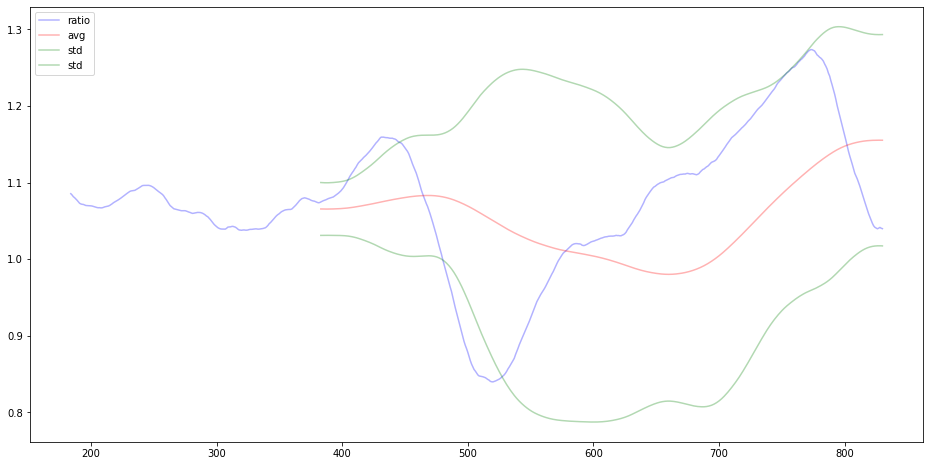

In [464]:
stock_df = clean_data[clean_data['symbol'] == 'AAPL']
stock_df['sma_50d_200d_ratio'].plot(figsize=(16,8), color='blue', alpha=0.3, label='ratio')
stock_df['sma_50d_200d_ratio_avg'].plot(figsize=(16,8), color='red', alpha=0.3, label='avg')
stock_df['sma_50d_200d_ratio_2std_up'].plot(figsize=(16,8), color='green', alpha=0.3, label='std')
stock_df['sma_50d_200d_ratio_2std_down'].plot(figsize=(16,8), color='green', alpha=0.3, label='std')
plt.legend();

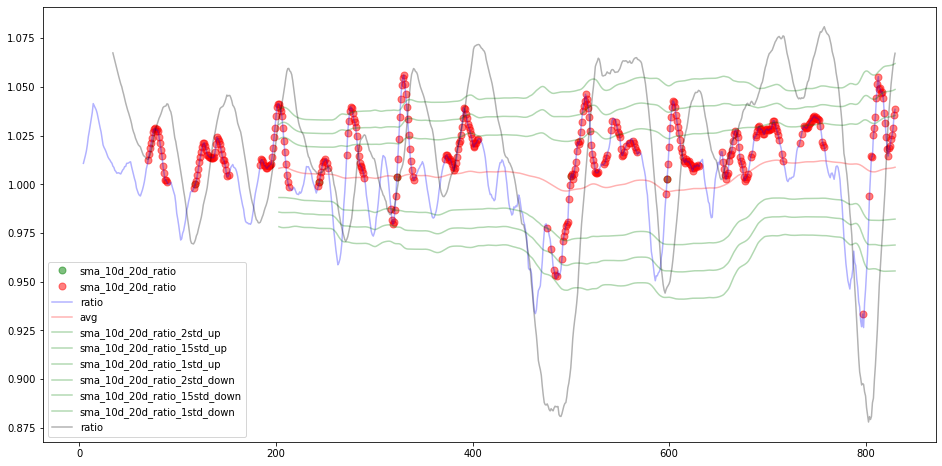

In [507]:
stock_df['my_buy'] = np.NaN
stock_df['my_buy'].mask(
                        (
                            (stock_df['sma_10d_20d_ratio_shift'] < 1)
                            & (stock_df['sma_10d_20d_ratio'] > 1)
                            & (stock_df['sma_20d_50d_ratio_shift'] < stock_df['sma_20d_50d_ratio'])
                        ), True, inplace=True)

stock_df['my_sell'] = np.NaN
stock_df['my_sell'].mask(
                        (
                            (stock_df['sma_20d_50d_ratio_shift'] < stock_df['sma_20d_50d_ratio'])
                        ), True, inplace=True)

stock_df[stock_df['my_buy'] == True]['sma_10d_20d_ratio'].plot(linestyle='', marker='o', color='green', alpha = 0.5, markersize = 7)
stock_df[stock_df['my_sell'] == True]['sma_10d_20d_ratio'].plot(linestyle='', marker='o', color='red', alpha = 0.5, markersize = 7)
stock_df['sma_10d_20d_ratio'].plot(figsize=(16,8), color='blue', alpha=0.3, label='ratio')
stock_df['sma_10d_20d_ratio_avg'].plot(figsize=(16,8), color='red', alpha=0.3, label='avg')
stock_df['sma_10d_20d_ratio_2std_up'].plot(figsize=(16,8), color='green', alpha=0.3)
stock_df['sma_10d_20d_ratio_15std_up'].plot(figsize=(16,8), color='green', alpha=0.3)
stock_df['sma_10d_20d_ratio_1std_up'].plot(figsize=(16,8), color='green', alpha=0.3)
stock_df['sma_10d_20d_ratio_2std_down'].plot(figsize=(16,8), color='green', alpha=0.3)
stock_df['sma_10d_20d_ratio_15std_down'].plot(figsize=(16,8), color='green', alpha=0.3)
stock_df['sma_10d_20d_ratio_1std_down'].plot(figsize=(16,8), color='green', alpha=0.3)
stock_df['sma_20d_50d_ratio'].plot(figsize=(16,8), color='black', alpha=0.3, label='ratio')
plt.legend();

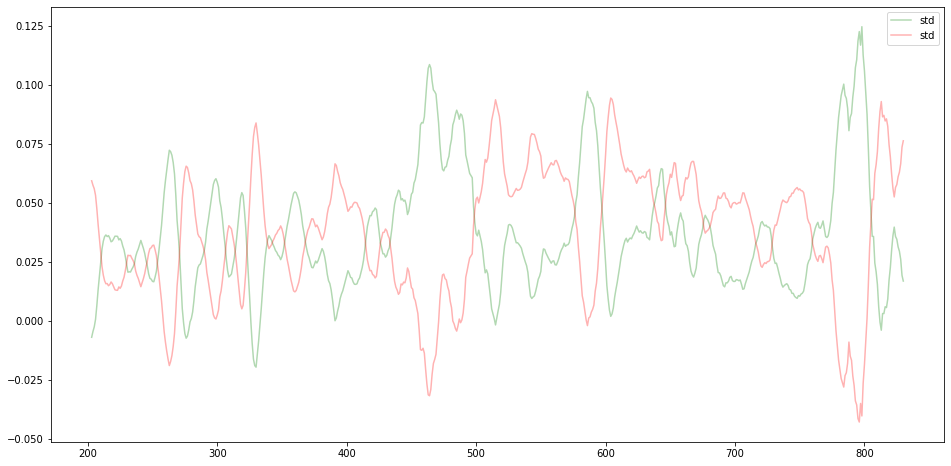

In [452]:
#(stock_df['sma_10d_20d_ratio'] -1).plot(figsize=(16,8), color='white', alpha=0.3, label='ratio')
#stock_df['sma_10d_20d_ratio_avg'].plot(figsize=(16,8), color='red', alpha=0.3, label='avg')
stock_df['sma_10d_20d_ratio_175std_up_diff'].plot(figsize=(16,8), color='green', alpha=0.3, label='std')
stock_df['sma_10d_20d_ratio_175std_down_diff'].plot(figsize=(16,8), color='red', alpha=0.3, label='std')
plt.legend();

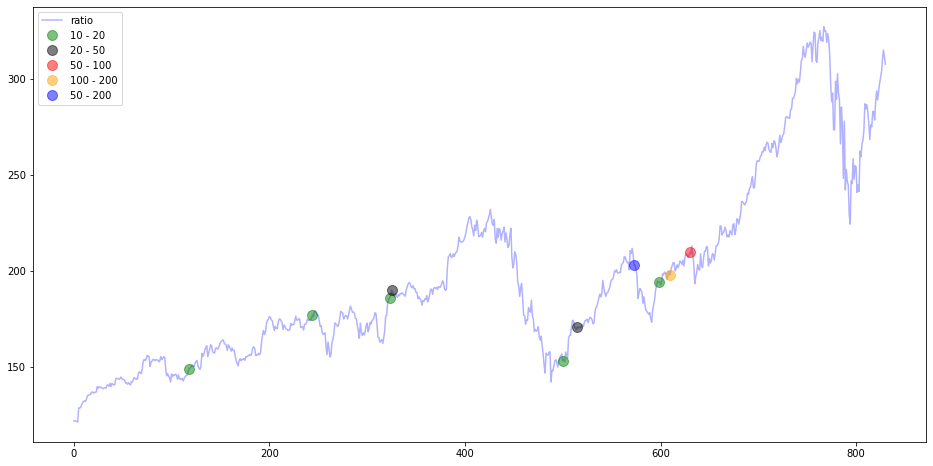

In [509]:
fig = plt.figure()
stock_df['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.3, label='ratio')
for x, y, t, a, b in [(10,20,'green', 20,50), (20,50,'black', 50, 100), (50,100,'red', 100, 200), (100,200,'orange', 100,200), (50,200,'blue', 50,200)]:
#for x, y in [(50,200)]:
    
    #plt.subplot(t)
    title = str(x) + ' - ' + str(y)
    stock_df['my_buy'] = np.NaN
    stock_df['my_buy'].mask((
                            (stock_df[f'sma_{x}d_{y}d_ratio_shift'] < 1)
                            & (stock_df[f'sma_{x}d_{y}d_ratio'] > 1)
                            & (stock_df[f'sma_{a}d_{b}d_ratio_shift'] < stock_df[f'sma_{a}d_{b}d_ratio'])
                        ), True, inplace=True)
    stock_df[stock_df['my_buy'] == True]['close_price_x'].plot(linestyle='', marker='o', color=t, alpha = 0.5, markersize = 10, label=title)
    
plt.legend();

## Charts

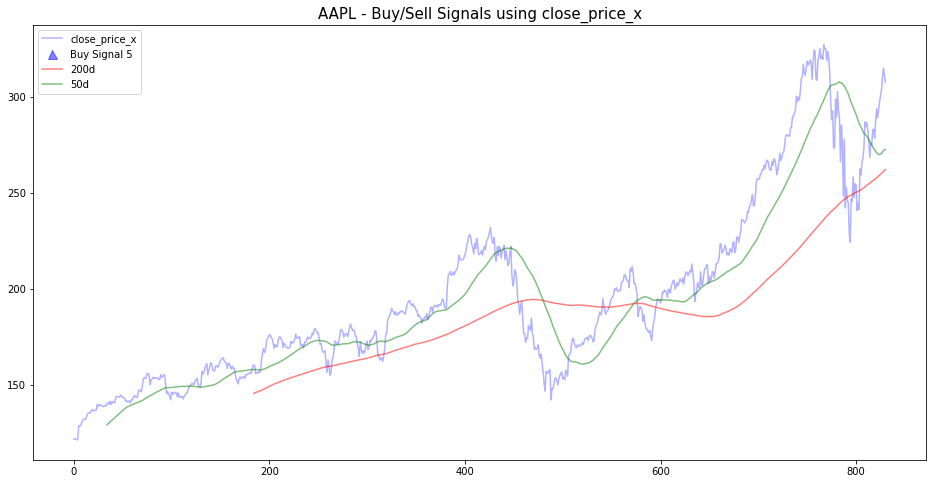

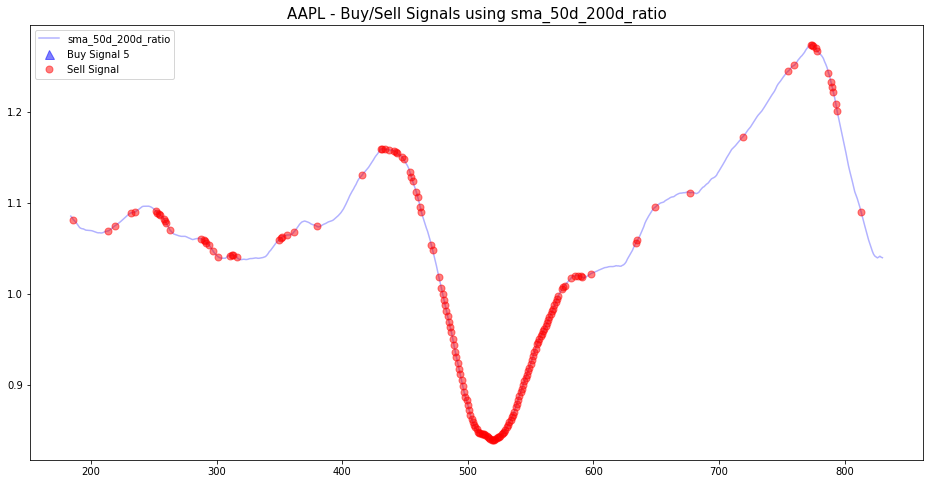

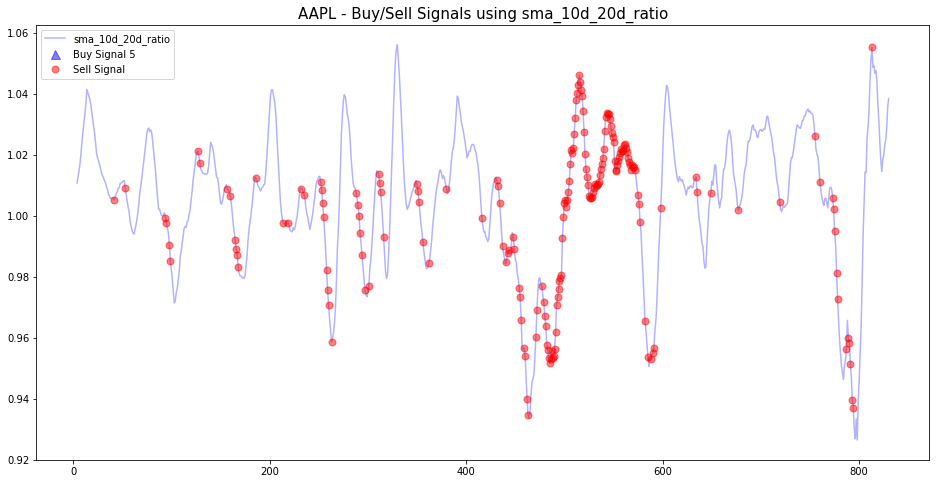

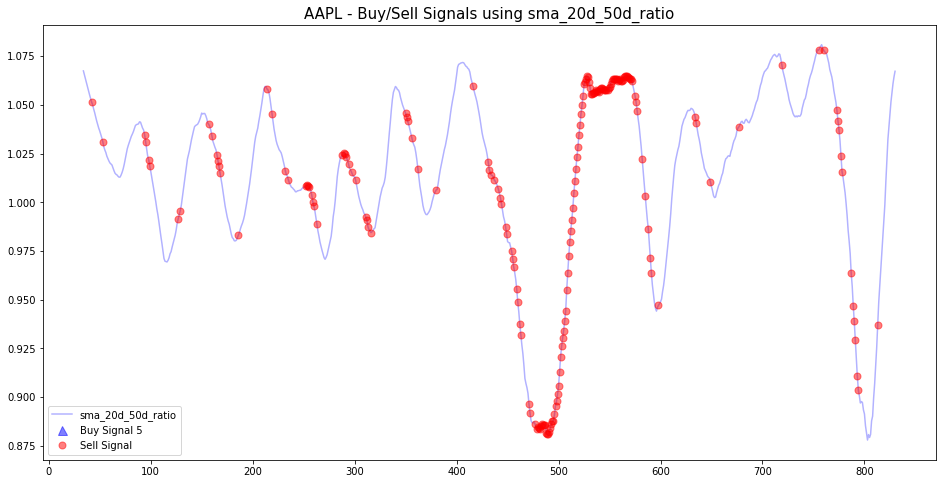

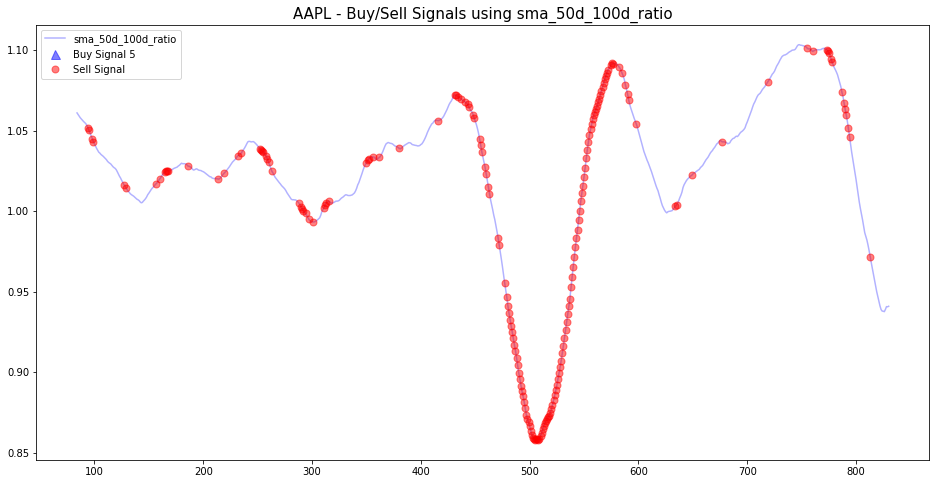

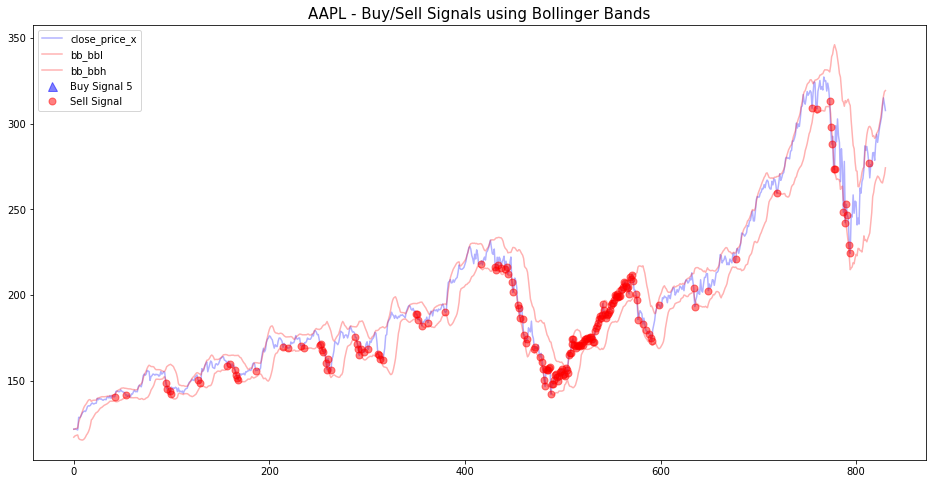

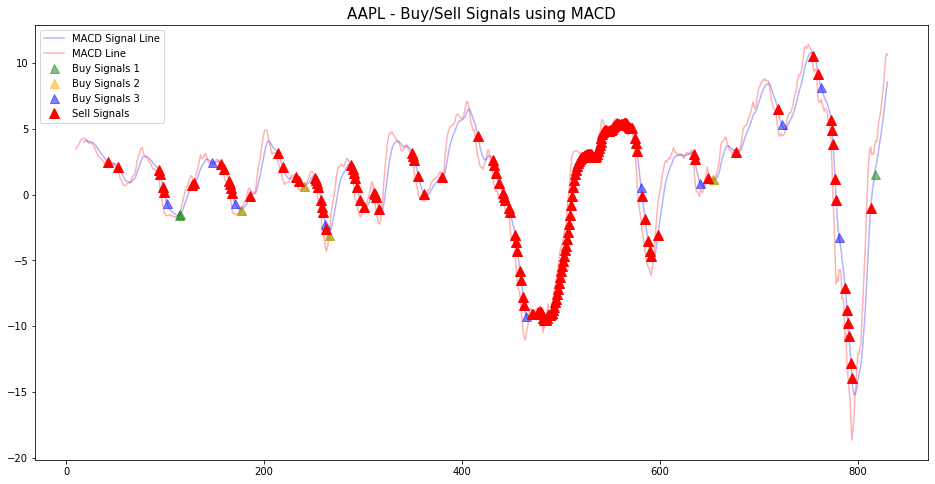

In [545]:
lstt = []
run_indicators_2(df, lstt, 'AAPL')
clean_data = pd.DataFrame(lstt[0])
# Run Charts
your_symbol = 'AAPL'
create_charts_1(clean_data, your_symbol, include_sell=False, what_to_print=[5])
create_charts_1(clean_data, your_symbol, 'sma_50d_200d_ratio', what_to_print=[5])
create_charts_1(clean_data, your_symbol, 'sma_10d_20d_ratio', what_to_print=[5])
create_charts_1(clean_data, your_symbol, 'sma_20d_50d_ratio', what_to_print=[5])
create_charts_1(clean_data, your_symbol, 'sma_50d_100d_ratio', what_to_print=[5])
create_charts_2(clean_data, your_symbol, what_to_print=[5] )
create_charts_3(clean_data, your_symbol)

## Backtest signals with exit strategies

In [ ]:
def backtest(df, buy_signal_column, support_column, stop_loss, max_holding_days, max_drop, money_per_trade, max_invested):

    # Create buy group1 column and uuid
    df['buy_group_backtest'] = np.NaN
    df['uuid'] = df['fake_index'].astype(str) + df['symbol']

    # A new group will be assigned when
    df['buy_group_backtest'].mask(df[buy_signal_column] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['sell_signal?'] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['low_price'] <= df[support_column], df['uuid'], inplace=True)

    # Forward fill groups
    df['buy_group_backtest'] = df['buy_group_backtest'].ffill()

    # Number of days holding 
    df['buy_group_backtest_holdings'] = df.groupby('buy_group_backtest')['timestamp'].rank(method='first')

    # Calculate group cumulative product
    df['buy_group_backtest_cum_return'] = df.groupby('buy_group_backtest').cumprod()['daily_return']
    
    # Create max drop limit
    df['buy_group_backtest_cum_return_shift'] = df['buy_group_backtest_cum_return'].shift(1)
    df['buy_group_backtest_cum_return_diff'] = df['buy_group_backtest_cum_return_shift'] - df['buy_group_backtest_cum_return']
    df['max_drop_limit'] = np.NaN
    df['max_drop_limit'].mask((df['buy_group_backtest_cum_return_diff'] >= max_drop) 
                              & (df['buy_group_backtest_holdings'] != 1), True, inplace=True)    
    
    # Create Loss Threshold
    df['loss_threshold'] = np.NaN
    df['loss_threshold'].mask(df['buy_group_backtest_cum_return'] <= stop_loss, True, inplace=True)

    # Number of days holding threshold
    df['holding_threshold'] = np.NaN
    df['holding_threshold'].mask(df['buy_group_backtest_holdings'] == max_holding_days, True, inplace=True)

    # Total Money Invested
    groups = set(df[df[buy_signal_column] == True]['buy_group_backtest'])
    df['initial_buy'] = np.NaN
    df['initial_buy'].mask(df['buy_group_backtest'].isin(groups), money_per_trade, inplace=True)
    df['today_value_of_investment'] = df['initial_buy'] * df['buy_group_backtest_cum_return']
    
    total_day = df.groupby('just_date').sum()['initial_buy'].reset_index()
    total_day.columns = ['just_date', 'daily_invested']
    df = pd.merge(df, total_day, on ='just_date', how='left')
    
    # Create buy group1 column and uuid
    df['buy_group_backtest'] = np.NaN
    df['uuid'] = df['fake_index'].astype(str) + df['symbol']

    # A new group will be assigned when
    df['buy_group_backtest'].mask((df[buy_signal_column] == True) & (df['daily_invested'] <= max_invested), df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['sell_signal?'] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['low_price'] <= df[support_column], df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['holding_threshold'] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['loss_threshold'] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['max_drop_limit'] == True, df['uuid'], inplace=True)
    
    # Forward fill groups
    df['buy_group_backtest'] = df['buy_group_backtest'].ffill()

    # Number of days holding
    df['buy_group_backtest_holdings'] = df.groupby('buy_group_backtest')['timestamp'].rank(method='first')

    # Calculate group cumulative product
    df['buy_group_backtest_cum_return'] = df.groupby('buy_group_backtest').cumprod()['daily_return']

    # Identify groups
    buy_groups = set(df[(df[buy_signal_column] == True)]['buy_group_backtest'])
    
    # Get last row of every group
    g = df[df['buy_group_backtest'].isin(buy_groups)].groupby('buy_group_backtest')
    returns = pd.concat([g.tail(1)])[['timestamp','symbol', 'industry', 'buy_group_backtest_cum_return', 'buy_group_backtest_holdings']]
    
    return returns, df

In [ ]:
def money_maker(data_frame, signal_name, returns, money_per_trade, print_which='all'):
    
    # Create list of Buy Groups
    buy_groups = set(data_frame[data_frame[signal_name] == True]['buy_group_backtest'])
    plot_me = data_frame[data_frame['buy_group_backtest'].isin(buy_groups)]
    plot_me['money_invested'] = (plot_me['buy_group_backtest_cum_return'] * money_per_trade)
    plot_me['money_return'] = plot_me['money_invested'] - money_per_trade
    
    print(signal_name)
    
    if print_which in ('all', '1'):
        # Money Invested
        plot_me.groupby('timestamp').sum()['money_invested'].plot(figsize=(14,6), color='blue', alpha=0.5, title='Money Invested')
        plt.show();
    
        # Money Gains daily
        plot_me.groupby('timestamp').sum()['money_return'].plot(figsize=(14,6), color='blue', alpha=0.5, title='Gains per Trade', label='Gains per Trade')

    # Cum sum of gains
    returns['money_back'] = (returns['return'] * money_per_trade) - money_per_trade
    gains_df = returns.groupby('date').sum()['money_back'].reset_index()
    gains_df['cum_sum'] = gains_df['money_back'].cumsum()
    gains_df.set_index('date', inplace=True)

    if print_which in ('all', '2'):
        gains_df['cum_sum'].plot(figsize=(14,6), color='green', alpha=0.5, title='Gains - Per Trade and Cum Sum', label = 'Cum Sum of Gains')
        plt.legend()
        plt.show()
    
    # Number of trades
    no_trades = data_frame[(data_frame[signal_name] == True) & (data_frame['buy_group_backtest'].isin(buy_groups))]

    if print_which in ('all', '2'):
        no_trades.groupby('just_date').count()['buy_group_backtest'].plot(figsize=(14,6), color='blue', alpha=0.5, title='Number of Trades per Day', label = 'Daily Trades')

    # Number of trades - Sum sum
    cumsum_trades = data_frame[(data_frame[signal_name] == True) & (data_frame['buy_group_backtest'].isin(buy_groups))]
    cumsum_trades = cumsum_trades.groupby('timestamp').count()['buy_group_backtest'].reset_index()
    cumsum_trades['cum_sum'] = cumsum_trades['buy_group_backtest'].cumsum()
    cumsum_trades.set_index('timestamp', inplace=True)

    if print_which in ('all', '3'):
        cumsum_trades['cum_sum'].plot(figsize=(14,6), color='green', alpha=0.5, title='Number of Trades - Daily and Cum Sum', label='Cum Sum of Trades')
        plt.legend()
        plt.show();
    
    if print_which in ('all', '4'):
        # Number of trades - Sum sum
        gain_trade = gains_df['cum_sum'] / cumsum_trades['cum_sum']
        gain_trade.plot(figsize=(14,6), color='green', alpha=0.5, title='Ratio of Cum Sum Gain / Cum Sum Trades',)
        plt.show();

### Backtest signal 1

In [ ]:
returns, data_frame = backtest(clean_data[clean_data['year'] > 2017], 'buy_signal?1', 'low_min_d10', 0.98, 30, 0.05, 100, 5000)
returns.columns = ['date','symbol', 'industry', 'return', 'days']
g = sns.catplot(x="industry", y="return", kind="violin", data=returns)
g.fig.set_size_inches(15,8);
returns.groupby('days').describe()['return']

In [ ]:
money_maker(data_frame, 'buy_signal?1', returns, 100)

In [ ]:
# Plot Close Price
colors = ['blue', 'green', 'red', 'orange', 'black', 'pink']
heatmap = []
for idx, tolerance in enumerate([0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    for max_drop in [0.02, 0.04, 0.06, 0.08, 0.1]:
        returns, data_frame = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?1', 'low_min_d30', tolerance, 30, max_drop, 100, 5000)
        returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
        heatmap.append([tolerance, max_drop, returns['return'].mean()])
        
to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
plt.subplots(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
plt.show()

### Backtest signal 2

In [ ]:
returns, data_frame = backtest(clean_data[clean_data['year'] > 2017], 'buy_signal?2', 'low_min_d10',0.98, 30, 0.05, 100, 5000)
returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
g = sns.catplot(x="industry", y="return", kind="violin", data=returns)
g.fig.set_size_inches(15,8);
h = returns.groupby('industry').mean()['return'].plot()
returns.groupby('industry').describe()['return']

In [ ]:
money_maker(data_frame, 'buy_signal?2', returns, 100)

In [ ]:
# Plot Close Price
colors = ['blue', 'green', 'red', 'orange', 'black', 'pink']
heatmap = []
for idx, tolerance in enumerate([0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    for max_drop in [0.02, 0.04, 0.06, 0.08, 0.1]:
        returns = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?2', 'low_min_d30', tolerance, 30, max_drop)
        returns.columns = ['symbol', 'industry', 'return', 'days']
        heatmap.append([tolerance, max_drop, returns['return'].mean()])
        
to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
plt.subplots(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
plt.show()

### Backtest signal 3

In [ ]:
returns, data_frame = backtest(clean_data[clean_data['year'] > 2017], 'buy_signal?3', 'low_min_d10',0.98, 30, 0.05, 100, 5000)
returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
g = sns.catplot(x="industry", y="return", kind="violin", data=returns)
g.fig.set_size_inches(15,8);
h = returns.groupby('industry').mean()['return'].plot()
returns.groupby('industry').describe()['return']

In [ ]:
money_maker(data_frame, 'buy_signal?3', returns, 100)

In [ ]:
# Plot Close Price
colors = ['blue', 'green', 'red', 'orange', 'black', 'pink']
heatmap = []
for idx, tolerance in enumerate([0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    for max_drop in [0.02, 0.04, 0.06, 0.08, 0.1]:
        returns, data_frame = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?3', 'low_min_d30', tolerance, 30, max_drop)
        returns.columns = ['symbol', 'industry', 'return', 'days']
        heatmap.append([tolerance, max_drop, returns['return'].mean()])
        
to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
plt.subplots(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
plt.show()

### Backtest signal 4

In [ ]:
returns, data_frame = backtest(clean_data[clean_data['year'] > 2017], 'buy_signal?4', 'low_min_d10',0.98, 30, 0.05, 100, 5000)
returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
g = sns.catplot(x="days", y="return", kind="violin", data=returns)
g.fig.set_size_inches(15,8);
h = returns.groupby('days').mean()['return'].plot()
returns.groupby('days').describe()['return']

In [ ]:
money_maker(data_frame, 'buy_signal?4', returns, 100)

In [ ]:
# Plot Close Price
colors = ['blue', 'green', 'red', 'orange', 'black', 'pink']
heatmap = []
for idx, tolerance in enumerate([0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    for max_drop in [0.02, 0.04, 0.06, 0.08, 0.1]:
        returns, data_frame = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?4', 'low_min_d30', tolerance, 30, max_drop,100,5000)
        returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
        heatmap.append([tolerance, max_drop, returns['return'].mean()])
        
to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
plt.subplots(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
plt.show()

In [ ]:


returns1, data_frame1 = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?1', 'low_min_d30',0.98, 30, 0.05, 100, 5000)
returns1.columns = ['date', 'symbol', 'industry', 'return', 'days']
money_maker(data_frame1, 'buy_signal?1', returns1, 100, '4')

returns2, data_frame2 = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?2', 'low_min_d30',0.98, 30, 0.05, 100, 5000)
returns2.columns = ['date', 'symbol', 'industry', 'return', 'days']
money_maker(data_frame2, 'buy_signal?2', returns2, 100, '4')

returns3, data_frame3 = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?3', 'low_min_d30',0.98, 30, 0.05, 100, 5000)
returns3.columns = ['date', 'symbol', 'industry', 'return', 'days']
money_maker(data_frame3, 'buy_signal?3', returns3, 100, '4')

returns4, data_frame4 = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?4', 'low_min_d30',0.98, 30, 0.05, 100, 5000)
returns4.columns = ['date', 'symbol', 'industry', 'return', 'days']
money_maker(data_frame4, 'buy_signal?4', returns4, 100, '4')

In [ ]:
money_maker(data_frame1, 'buy_signal?1', returns1, 100, '2')
money_maker(data_frame2, 'buy_signal?2', returns2, 100, '2')
money_maker(data_frame3, 'buy_signal?3', returns3, 100, '2')
money_maker(data_frame4, 'buy_signal?4', returns4, 100, '2')

In [ ]:
clean_data.head()

In [ ]:
def compare_years(max_drop_list, tolerance_list, years_list, signal_name, your_df):
    
    for idxx, year in enumerate(years_list):
        print(year)
        heatmap = []
        for idx, tolerance in enumerate(tolerance_list):
            for max_drop in max_drop_list: 
                returns = backtest(your_df[your_df['year'] == year], signal_name, 'low_min_d30', tolerance, 30, max_drop)
                returns.columns = ['symbol', 'industry', 'return', 'days']
                heatmap.append([tolerance, max_drop, returns['return'].mean()])
        to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
        pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
        sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
    
        plt.show()

In [ ]:
compare_years(max_drop_list=[0.01, 0.02, 0.03, 0.04, 0.05],
              tolerance_list=[0.9, 0.93, 0.96, 0.99],
              years_list=[2017, 2018, 2019, 2020],
              signal_name='buy_signal?1',
              your_df=clean_data)

In [ ]:
compare_years(max_drop_list=[0.01, 0.02, 0.03, 0.04, 0.05],
              tolerance_list=[0.9, 0.93, 0.96, 0.99],
              years_list=[2017, 2018, 2019, 2020],
              signal_name='buy_signal?2',
              your_df=clean_data)

In [ ]:
compare_years(max_drop_list=[0.01, 0.02, 0.03, 0.04, 0.05],
              tolerance_list=[0.9, 0.93, 0.96, 0.99],
              years_list=[2017, 2018, 2019, 2020],
              signal_name='buy_signal?3',
              your_df=clean_data)

In [ ]:
compare_years(max_drop_list=[0.01, 0.02, 0.03, 0.04, 0.05],
              tolerance_list=[0.9, 0.93, 0.96, 0.99],
              years_list=[2017, 2018, 2019, 2020],
              signal_name='buy_signal?4',
              your_df=clean_data)

In [ ]:
to_plot = clean_data[(clean_data['buy_signal?1'] == True)]
to_plot['next_21d_return'].mean()

In [ ]:
to_plot['macd_hist_3d_min_coef'].plot.hist()

In [ ]:
test = clean_data[clean_data['symbol'] == 'AAPL']
test['buy_reno'] = np.NaN
test['buy_reno'].mask(
                                        (
                                            #(test['stationary_sma_10d_zscore_shift_2'] <= test['stationary_sma_10d_zscore_shift'])
                                            #(test['stationary_sma_10d_zscore'] > test['stationary_sma_10d_zscore_shift'])
                                            #(test['stationary_sma_10d_zscore'] < test['stationary_sma_10d_zscore_max'])
                                            (test['stationary_sma_10d_zscore_shift'] == test['stationary_sma_10d_zscore_min'])
                                            #(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
                                            #& (df_2['stationary_sma_10d_zscore_shift_2'] <= (0.8 * df_2['stationary_sma_10d_zscore_min_all_shift_2']))
                                            & (test['moving_2d_return'] > 1)
                                            #& (test['rsi_bins'] < test['rsi_175_max_bin'])
                                            #& (test['rsi_bins'] > test['rsi_175_min_bin'])
                                            #& (test['macd_hist'] >= test['macd_hist_1d_shift'])
                                        )
                                        , True, inplace=True)

test['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.5)
test[test['buy_reno'] == True]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
#test['stationary_sma_10d_zscore'].plot(figsize=(16,8), color='blue', alpha=0.5)
#test['stationary_sma_10d_zscore_shift'].plot(figsize=(16,8), color='red', alpha=0.5)
#test['sma_20d'].plot(figsize=(16,8), color='red', alpha=0.5)

In [ ]:
print(test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
    #& (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_21d_return'] > 1)].count()['index'])

print(test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
   # & (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_21d_return'] < 1)].count()['index'])


In [ ]:
test['macd_line'].plot(figsize=(16,8), color='blue', alpha=0.5)

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
    #& (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_14d_return'] > 1)]['macd_line'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
   # & (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_14d_return'] < 1)]['macd_line'].plot(linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signal 1')


In [ ]:
test['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.5)
#test['sma_10d'].plot(figsize=(16,8), color='green', alpha=0.5)
#test['sma_20d'].plot(figsize=(16,8), color='red', alpha=0.5)
#test[(test['low_min_d10'] > test['low_min_d10_shift1_10']) 
    #& (test['low_min_d10_shift1_10'] > test['low_min_d10_shift2_20'])
    #& (test['stationary_sma_100d_zscore'] <= (0.8 * test['stationary_sma_100d_zscore_min_all']))
    #& (test['sma_10d'] > test['sma_20d']) ]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    #& (test['sma_10d_shift'] < test['sma_20d_shift'])

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_35_min_bin_low'] < test['rsi_bins'])
    & (test['rsi_bins'] < 7)
    & (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_14d_return'] > 1)]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_35_min_bin_low'] < test['rsi_bins'])
    & (test['rsi_bins'] < 7)
    & (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_14d_return'] < 1)]['close_price_x'].plot(linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signal 1')


In [ ]:
test['rsi_bins'].plot(figsize=(16,8), color='blue', alpha=0.5)
#test['sma_10d'].plot(figsize=(16,8), color='green', alpha=0.5)
#test['sma_20d'].plot(figsize=(16,8), color='red', alpha=0.5)
#test[(test['low_min_d10'] > test['low_min_d10_shift1_10']) 
    #& (test['low_min_d10_shift1_10'] > test['low_min_d10_shift2_20'])
    #& (test['stationary_sma_100d_zscore'] <= (0.8 * test['stationary_sma_100d_zscore_min_all']))
    #& (test['sma_10d'] > test['sma_20d']) ]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    #& (test['sma_10d_shift'] < test['sma_20d_shift'])

print(test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
    & (test['next_14d_return'] > 1)].count()['index'])

print(test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
    & (test['rsi_bins'] < 7)
    & (test['next_14d_return'] < 1)].count()['index'])

In [ ]:
test['sma_10d_coef'].plot(figsize=(16,8), color='blue', alpha=0.5)
test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < 7)
    & (test['next_14d_return'] > 1)]['sma_10d_coef'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < 7)
    & (test['next_14d_return'] < 1)]['sma_10d_coef'].plot(linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signal 1')


In [ ]:
clean_data = 0
df_1 = 0
test = 0
data_frame = 0
data_frame1 = 0
data_frame2 = 0
data_frame3 = 0
data_frame4 = 0

In [76]:


# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('clean_data', 2463489991),
 ('df', 27830886),
 ('df_today', 8902027),
 ('df_1', 2521452),
 ('metrics', 989641),
 ('metrics_b', 928521),
 ('metrics_a', 867273),
 ('list_of_good', 33000),
 ('df1s', 9032),
 ('my_stocks', 7992),
 ('last_days_symbol', 2280),
 ('BeautifulSoup', 2008),
 ('Session', 1472),
 ('ThreadPool', 1064),
 ('Process', 896),
 ('timedelta', 400),
 ('create_charts_1', 144),
 ('create_charts_2', 144),
 ('create_charts_3', 144),
 ('create_dataframe', 144),
 ('finviz_pull', 144),
 ('get_prices', 144),
 ('mean', 144),
 ('median', 144),
 ('mp_handler', 144),
 ('run_indicators_2', 144),
 ('stdev', 144),
 ('yahoo_finance_query', 144),
 ('min_date', 136),
 ('relevant_columns', 128),
 ('processes', 104),
 ('symbol', 96),
 ('data', 88),
 ('mp', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('sns', 88),
 ('Manager', 72),
 ('Pool', 72),
 ('cpu_count', 72),
 ('L', 64),
 ('manager', 64),
 ('p', 64),
 ('p1', 64),
 ('previous_5days', 59),
 ('max_index', 32),
 ('days', 28),
 ('i', 28),
 